<a href="https://colab.research.google.com/github/psagrera/Data-Science-Advanced/blob/main/DeepLearning/Session2/S2_DL_Challenge/S2_DL_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Deep Learning</center>

# Challenge S2: Machine Learning Basics en TensorFlow

## Objetivos

El objetivo de este challenge es familiarizarnos con TensorFlow y con su funcionamiento básico enfrentandose a problemas de regresión y clasificación.


## Regresión

### Punto de partida

El punto de partida se corresponde con el código que hemos visto en el worksheet:

In [268]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# Cargamos el dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

# Creamos las estructuras que contienen las categorías
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # lista de todos los valores únicos contenidos en una columna
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Definimos nuestra función de input

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # función interna, esto es lo que será devuelto
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # crea un objeto tf.data.Dataset que contendrá datos y etiquetas 
    if shuffle:
      ds = ds.shuffle(1000)  # con esta línea aleatorizamos la selección de elementos
    ds = ds.batch(batch_size).repeat(num_epochs)  # divide el dataset en batches el número de veces especificado por num_epocs 
    return ds  # devuelve un batch del dataset
  return input_function  # devuelve el objeto completo para ser utilizado.

train_input_fn = make_input_fn(dftrain, y_train)  # así llamamos a la función que se nos devuelve para extraer el objeto dataset que inyectaremos en el modelo
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


# Creamos el modelo
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

# Lo entrenamos
linear_est.train(train_input_fn)  # entrenamos el modelo
result = linear_est.evaluate(eval_input_fn)  # obtenemos las estimaciones del conjunto de evaluación

clear_output()  # limpiamos la consola
print(result['accuracy'])  # la viariable result es un diccionario con los resultados de nuestro modelo

0.7348485


In [298]:
y_train.value_counts()

0    384
1    243
Name: survived, dtype: int64

## Tareas


### Cambiando el histograma

En el worksheet tenemos el ejemplo de un histograma con las posibilidades de supervivencia de cada individuo del conjunto de evaluación, representad a continuación el mismo histograma pero con el conjunto de entrenamiento.


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7_56i6zm/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


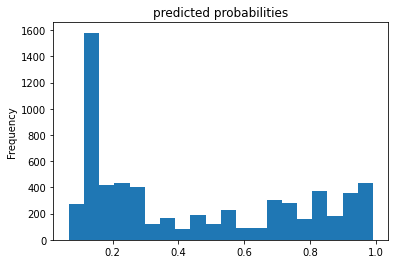

In [269]:
pred_dicts = list(linear_est.predict(train_input_fn)) 

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) 

probs.plot(kind='hist', bins=20, title='predicted probabilities')

¿Y si lo que queremos es pintar el histograma de la mortalidad de cada individuo del conjunto de evaluación?

Pista, mirad la estructura del diccionario que devuelve *linear_est.predict()*

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7_56i6zm/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


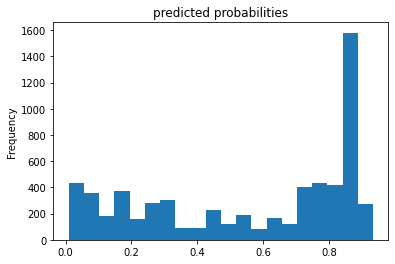

In [270]:
pred_dicts = list(linear_est.predict(train_input_fn)) 

probs = pd.Series([pred['probabilities'][0] for pred in pred_dicts]) 

probs.plot(kind='hist', bins=20, title='predicted probabilities')

### Cambiando el conjunto de entrenamiento

Sabemos que uno de los factores más importantes en el entrenamiento de redes neuronales es la cantidad y calidad del conjunto de entrenamiento. ¿Es igual de importante en regresión lineal?

Vamos a ver cuál sería el porcentaje de acierto de nuestro modelo si entrenamos con la mitad del conjunto de entrenamiento:

In [271]:
# First approach , manually splitting the dataset to the half, selecting by position
half_dataset_x1 = dftrain.iloc[0:314]
half_dataset_y1 = y_train.iloc[0:314]


In [272]:
half_dataset_x1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 314 non-null    object 
 1   age                 314 non-null    float64
 2   n_siblings_spouses  314 non-null    int64  
 3   parch               314 non-null    int64  
 4   fare                314 non-null    float64
 5   class               314 non-null    object 
 6   deck                314 non-null    object 
 7   embark_town         314 non-null    object 
 8   alone               314 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 22.2+ KB


In [273]:
len(half_dataset_y1)

314

In [274]:
# Second approach, using panda's sample function to split the dataset 
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')

half_dataset_x2 = dftrain.sample(frac=0.5,random_state=1)
half_dataset_y2 = half_dataset_x2.pop('survived')

In [275]:
half_dataset_x2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 301 to 577
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 314 non-null    object 
 1   age                 314 non-null    float64
 2   n_siblings_spouses  314 non-null    int64  
 3   parch               314 non-null    int64  
 4   fare                314 non-null    float64
 5   class               314 non-null    object 
 6   deck                314 non-null    object 
 7   embark_town         314 non-null    object 
 8   alone               314 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 24.5+ KB


In [276]:
len(half_dataset_y2)

314

In [296]:
half_dataset_y2.value_counts()

0    190
1    124
Name: survived, dtype: int64

In [277]:
# Accurary training with the half of the dataset (second approach)

train_input_fn_half_x1 = make_input_fn(half_dataset_x1, half_dataset_y1)  # así llamamos a la función que se nos devuelve para extraer el objeto dataset que inyectaremos en el modelo
eval_input_fn_half_x = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

# Creamos el modelo
linear_est_half = tf.estimator.LinearClassifier(feature_columns=feature_columns)

# Lo entrenamos
linear_est_half.train(train_input_fn_half_x1)  # entrenamos el modelo
result = linear_est_half.evaluate(eval_input_fn_half_x)  # obtenemos las estimaciones del conjunto de evaluación

clear_output()  # limpiamos la consola
print(result['accuracy'])  # la viariable result es un diccionario con los resultados de nuestro modelo

0.7462121


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7_56i6zm/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


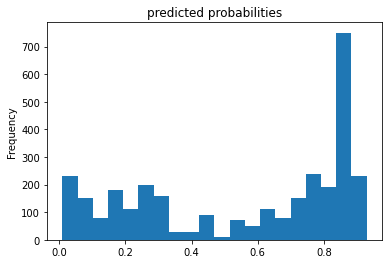

In [278]:
# Predicted probabilities - Class 0 
pred_dicts = list(linear_est.predict(train_input_fn_half_x1)) 

probs = pd.Series([pred['probabilities'][0] for pred in pred_dicts]) 

probs.plot(kind='hist', bins=20, title='predicted probabilities')

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7_56i6zm/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


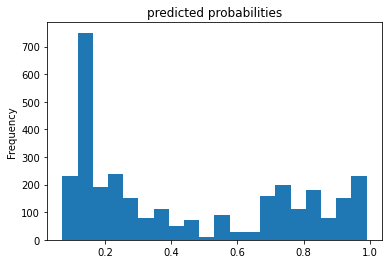

In [279]:
# Predicted probabilities - Class 1 
pred_dicts = list(linear_est.predict(train_input_fn_half_x1)) 

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) 

probs.plot(kind='hist', bins=20, title='predicted probabilities')

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7_56i6zm/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


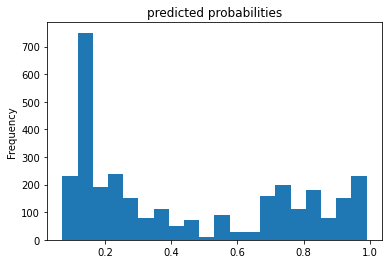

In [280]:
pred_dicts = list(linear_est.predict(train_input_fn_half_x1)) 

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) 

probs.plot(kind='hist', bins=20, title='predicted probabilities')

Y si entrenamos con una décima parte de en nuestro ejemplo original?

In [281]:
# Second approach, using panda's sample function to split the dataset 
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')

dec_dataset_x2 = dftrain.sample(frac=0.1,random_state=1)
dec_dataset_y2 = dec_dataset_x2.pop('survived')

In [282]:
dec_dataset_x2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 301 to 34
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 63 non-null     object 
 1   age                 63 non-null     float64
 2   n_siblings_spouses  63 non-null     int64  
 3   parch               63 non-null     int64  
 4   fare                63 non-null     float64
 5   class               63 non-null     object 
 6   deck                63 non-null     object 
 7   embark_town         63 non-null     object 
 8   alone               63 non-null     object 
dtypes: float64(2), int64(2), object(5)
memory usage: 4.9+ KB


In [283]:
len(dec_dataset_y2)

63

In [297]:
dec_dataset_y2.value_counts()

0    36
1    27
Name: survived, dtype: int64

In [284]:
train_input_fn_dec = make_input_fn(dec_dataset_x2,dec_dataset_y2 )  # así llamamos a la función que se nos devuelve para extraer el objeto dataset que inyectaremos en el modelo
eval_input_fn_dec = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


# Creamos el modelo
linear_est_dec = tf.estimator.LinearClassifier(feature_columns=feature_columns)

# Lo entrenamos
linear_est_dec.train(train_input_fn_dec)  # entrenamos el modelo
result = linear_est_dec.evaluate(eval_input_fn_dec)  # obtenemos las estimaciones del conjunto de evaluación

#clear_output()  # limpiamos la consola
print(result['accuracy']) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpzn65s3sf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpzn65s3sf/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20...
INFO:tensorflow:Saving checkpoints for 20 into /tmp/tmpzn65s3sf/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20...
INFO:tensorflow:Loss for final step: 0.5391088.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-04-16T09:14:41Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpzn65s3sf/model.ckpt-20
INFO:tensorf

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7_56i6zm/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


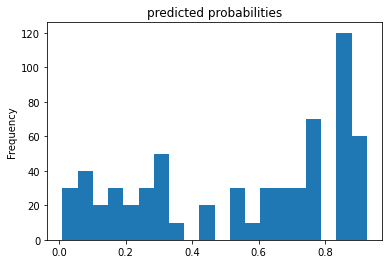

In [285]:
pred_dicts = list(linear_est.predict(train_input_fn_dec)) 

probs = pd.Series([pred['probabilities'][0] for pred in pred_dicts]) 

probs.plot(kind='hist', bins=20, title='predicted probabilities')

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7_56i6zm/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


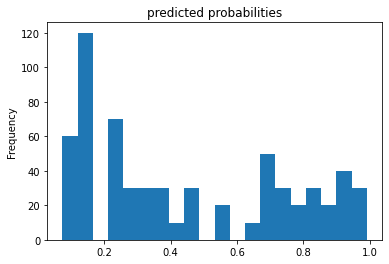

In [286]:
pred_dicts = list(linear_est.predict(train_input_fn_dec)) 

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) 

probs.plot(kind='hist', bins=20, title='predicted probabilities')

Por último, vamos a mostrar también el accuracy que tenemos sobre el conjunto de datos de entrenamiento (podemos utilizar cualquiera de los modelos que acabamos de entrenar)


### Conclusiones:
 
¿Hay mucha diferencia entre el entrenamiento original y el que hemos realizado con datos diezmados? ¿Por qué?

In [287]:
# No existe mucha diferencia en cuanto al accuracy, al reducir el numero de datos 
# La complejidad del problema a resolver no es muy grande (probabilidad de supervencia , dos clases).
# Parece que con pocas muestras de ambas clases (sin que haya mucho desbalanceo) , el accuracy es parecido, con lo que entiendo que para mejorar el modelo, habria que tocar
# otros parametros principalmente, si bien , incrementar el numero de muestras ayudaria tambien.
                                                                

## Regresión

### Punto de partida

El punto de partida se corresponde con el código que hemos visto en el worksheet:

In [288]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
train_y = train.pop('Species')
test_y = test.pop('Species')

def input_fn(features, labels, training=True, batch_size=256):
    # Convertimos los datos al tipo dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Aleatorizamos y seleccionamos los datos si estamos en modo train.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

# Feature columns describe cómo se utilizan las feature columns
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

# Definimos una DNN con 2 capas ocultas con 30 y 10 nodos ocultos cada una.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Dos capas ocultas de 30 y 10 nodos respectivamente
    hidden_units=[10,10,10],
    # El modelo debe poder distinguir entre 3 clases
    n_classes=3)

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# Hemos definido lambda para evitar crear una función previamente (los detalles de implementación no son importantes ahora)


eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))
clear_output()
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))






Test set accuracy: 0.700



### Ajustando los parámetros del entrenamiento

Como sabemos, el número de capas y neuronas ocultas es un número arbitrario y necesitamos de muchos experimentos y test para poder determinar la mejor elección de estos valores.

Vamos a probar en las siguientes celdas a probar las siguientes arquitecturas:

- 1 capa oculta de 10 neuronas
- 1 capa oculta de 50 neuronas
- 2 capas ocultas de 30 y 10 neuronas respectivamente
- 3 capas ocultas de 30, 20 y 10 neuronas respectivamente.
- 5 capas ocultas de 30, 20, 10, 10 y 10 neuronas respectivamente.


In [289]:
# 1 capa oculta de 10 neuronas
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Dos capas ocultas de 30 y 10 nodos respectivamente
    hidden_units=[10],
    # El modelo debe poder distinguir entre 3 clases
    n_classes=3)

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# Hemos definido lambda para evitar crear una función previamente (los detalles de implementación no son importantes ahora)


eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))
clear_output()
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))



Test set accuracy: 0.267



In [290]:
# 1 capa oculta de 50 neuronas
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Dos capas ocultas de 30 y 10 nodos respectivamente
    hidden_units=[50],
    # El modelo debe poder distinguir entre 3 clases
    n_classes=3)

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# Hemos definido lambda para evitar crear una función previamente (los detalles de implementación no son importantes ahora)


eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))
clear_output()
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))



Test set accuracy: 0.800



In [291]:
# 2 capas ocultas de 30 y 10 neuronas respectivamente
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Dos capas ocultas de 30 y 10 nodos respectivamente
    hidden_units=[30,20],
    # El modelo debe poder distinguir entre 3 clases
    n_classes=3)

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# Hemos definido lambda para evitar crear una función previamente (los detalles de implementación no son importantes ahora)


eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))
clear_output()
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.933



In [292]:
#3 capas ocultas de 30, 20 y 10 neuronas respectivamente.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Dos capas ocultas de 30 y 10 nodos respectivamente
    hidden_units=[30,30,10],
    # El modelo debe poder distinguir entre 3 clases
    n_classes=3)

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# Hemos definido lambda para evitar crear una función previamente (los detalles de implementación no son importantes ahora)


eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))
clear_output()
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.967



In [293]:
#5 capas ocultas de 30, 20, 10, 10 y 10 neuronas respectivamente.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Dos capas ocultas de 30 y 10 nodos respectivamente
    hidden_units=[30,30,10,10,10],
    # El modelo debe poder distinguir entre 3 clases
    n_classes=3)

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# Hemos definido lambda para evitar crear una función previamente (los detalles de implementación no son importantes ahora)


eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))
clear_output()
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.967



### Conclusiones

¿Qué idea básica extraes de los experimentos?

¿Mejora siempre la red al aumentar su tamaño y/o profundidad?


In [294]:
# Con una sola capa, si aumentamos ancho, mejora la red, en este caso con un valor de anchura de 70 neuronas alcazmos un accuracy de 0.9. 
# Si aumentamos profundidad y solo el ancho de la capa de entrada , pero por debajo de un valor que mejore el primer experimento, la red  .
# Si aumentamos profundidad y ancho de las primeras capas , mejora el accuracy de la red.
# No siempre mejora la red al aumentar la profundidad. Una sola capa de 50 es mejor que tres de 10.
# Siempre mejora al aumentar el ancho (hasta cierto punto). Parece que aumentando la anchura , se aprenden mejor las relaciones lineales
# y que la profundidad funcionara mejor en relaciones no lineales.